Import necessary libaries

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import spacy
from collections import Counter
from wordcloud import WordCloud
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-Processing

In [56]:
#Read csv files
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

#Create Dataframes
train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=labels_to_drop)

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
stop.extend([])
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)


Save Pre Processed Dataframe

In [57]:
train_set.to_csv('processed_df')
test_set.to_csv('processed_test')

Read Pre Processed Dataframe

In [97]:
data = pd.read_csv('processed_df')
train_set = pd.DataFrame(data)

data = pd.read_csv('processed_test')
test_set = pd.DataFrame(data)

Extra stopword removal(with no effect)

In [98]:
stop = ['ο', 'εγώ', 'σε', 'εχω', 'μου','σου','εσυ','ως','σαν']

train_set['Text'] = train_set['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

Word Cloud

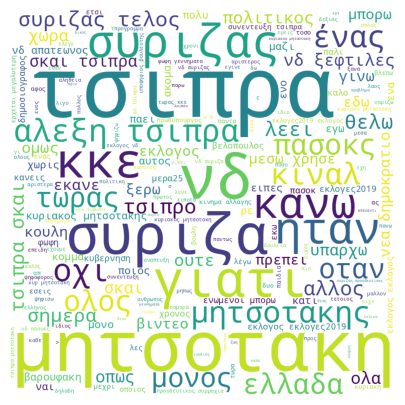

In [104]:
wordcloud = WordCloud(width=800, height=800,background_color='white').generate(' '.join(train_set['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Token Frequency

In [105]:
tokens = ' '.join(train_set['Text']).split()
token_counts = Counter(tokens)
print(token_counts.most_common(10))

[('τσιπρα', 9690), ('νδ', 8170), ('μητσοτακη', 7005), ('εκλογος', 4325), ('συριζας', 4189), ('κκε', 3525), ('συριζα', 3401), ('2019', 3164), ('σκαι', 2943), ('μητσοτακης', 2254)]


Text Length Distribution

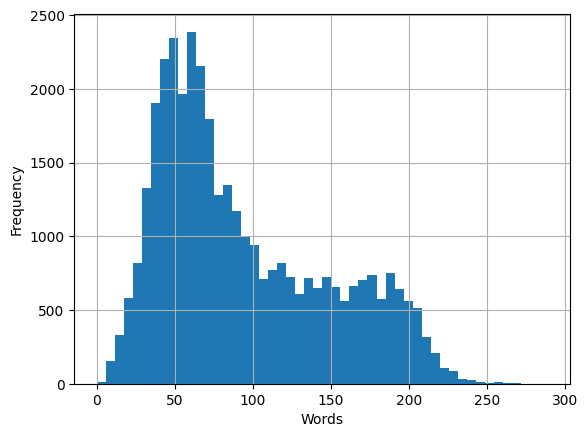

In [106]:
df = train_set.copy()

df['Text'] = df['Text'].apply(len)
df['Text'].hist(bins=50)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Vectorization and Label Encoding

In [107]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

#train_set = train_set.head(10000)


X_train = vectorizer.fit_transform(train_set['Text'])
X_test = vectorizer.fit_transform(test_set['Text'])

Y_train = encoder.fit_transform(train_set['Sentiment'])

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3)

Classification:

Average F1 training score: 0.9144743949331801
Average F1 validation score: 0.3685520722270606


Average Recall training score: 0.9144662799757597
Average Recall validation score: 0.36864136864136865


Average Precision training score: 0.9145525834342542
Average Precision validation score: 0.36878075496400375
Best F1 score: 0.3685520722270606


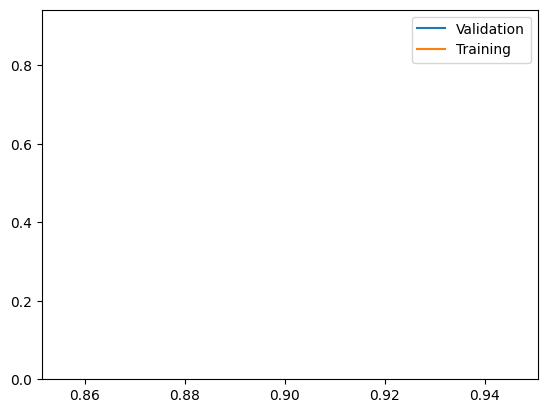

In [110]:
list_f1=[]
list_recall = []
list_precision = []
list_f1_train=[]
list_recall_train = []
list_precision_train = []
list_sample_size=[]

best_score = 0

for times in range(10):
  X, X_unused, y, y_unused = train_test_split(X_train, Y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000,C=10.0,multi_class='auto',solver='lbfgs',tol=1e-8)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  results = classifier.predict(X_val)

  f1_train = f1_score(y, results_train,average='weighted')
  precision_train = precision_score(y,results_train,average='weighted')
  recall_train = recall_score(y,results_train,average='weighted')

  f1 = f1_score(Y_val, results,average='weighted')
  precision = precision_score(Y_val, results,average='weighted')
  recall = recall_score(Y_val, results,average='weighted')

  if f1 > best_score:
    best_score = f1
  
  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_recall.append(recall)
  list_recall_train.append(recall_train)
  list_precision.append(precision)
  list_precision_train.append(precision_train)
  list_sample_size.append((times * 0.1 + 0.001))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

print("Average F1 training score: " + str(sum(list_f1_train) / len(list_f1_train)))
print("Average F1 validation score: " + str(sum(list_f1) / len(list_f1)))
print("\n")
print("Average Recall training score: " + str(sum(list_recall_train) / len(list_recall_train)))
print("Average Recall validation score: " + str(sum(list_recall) / len(list_recall)))
print("\n")
print("Average Precision training score: " + str(sum(list_precision_train) / len(list_precision_train)))
print("Average Precision validation score: " + str(sum(list_precision) / len(list_precision)))

print("Best F1 score: " + str(best_score))



Logistic Regression Classifier

$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Penalty} & \text{C} & \text{Multi Class} & \text{Max Iterations} & \text{Solver} & \text{Avg F1-Score}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{100} & \text{lbfgs} & \text{35.6\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{500} & \text{lbfgs} & \text{35.9\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{34.9\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{36.1\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.2\%}\\
\hline
\text{L2} & \text{5.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.9\%}\\
\hline
\text{L2} & \text{10.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.2\%}\\
\hline
\text{L2} & \text{20.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{34.9\%}\\
\hline
\text{L2} & \text{100.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.4\%}\\
\hline
\end{array}
$
$$ $$
C > 10.0 ,really great f1 training values > 0.95 but really long time to execute. $$ $$
C = 100.0 took : 4 minutes 1 seconds with avg training f1: 96.5% but only 35.4% avg f1 test.$$ $$
C < 1.0,good f1 validation score but low training f1